## SETUP

In [1]:
# Install the nightly version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!pip uninstall -y -q tensorflow keras estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text-nightly==2.11.0.dev20220817

     |████████████████████████████████| 5.9 MB 28.8 MB/s 


In [2]:
!pip install -U -q tf-nightly==2.11.0.dev20220817

     |████████████████████████████████| 582.0 MB 14 kB/s 
     |████████████████████████████████| 5.9 MB 51.0 MB/s 
     |████████████████████████████████| 439 kB 66.6 MB/s 
     |████████████████████████████████| 1.7 MB 53.0 MB/s 


In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## DATASET

Use TensorFlow Datasets to load the Portuguese-English translation dataset from the TED Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteX7YIWC/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteX7YIWC/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteX7YIWC/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## TOKENIZER

tokenize the text, so that each element is represented as a token or token ID (a numeric representation).

Subword tokenization take care of common/recurring word parts, such as 'ing' and 'tion', as well as common words like 'are' and 'you'.

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

Create tokenizer functions

The following function drops examples longer than the maximum number of tokens (MAX_TOKENS). Without limiting the size of sequences, the performance may be negatively affected.

In [8]:
MAX_TOKENS = 128

def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

Positional Encodings

In [10]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # Apply the sine function to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # Apply the cosine function to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## TRANSFORMER MODEL

Point-wise feed-forward neural network

In [11]:
def point_wise_feed_forward_network(
  d_model, # Input/output dimensionality.
  dff # Inner-layer dimensionality.
  ):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
      tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
  ])

Encoder

An encoder consists of N layers.

Each of these encoder layer consists of sublayers:

* A multi-head attention layer (with a padding mask), implemented with tf.keras.layers.MultiHeadAttention.
* A point-wise feed-forward network with tf.keras.layers.Dense.
* Each of these sublayers has a residual/skip connection around it, followed by layer normalization (tf.keras.layers.LayerNormalization). Residual connections help in avoiding the vanishing gradient problem in deep networks.

Therefore, the output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis (the dimensionality of the input/output). There are N encoder layers in a Transformer.

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super(EncoderLayer, self).__init__()


    # Multi-head self-attention.
    self.mha = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate,
        )
    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, training, mask):

    # A boolean mask.
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      attention_mask = mask1 & mask2
    else:
      attention_mask = None

    # Multi-head self-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_output = self.mha(
        query=x,  # Query Q tensor.
        value=x,  # Value V tensor.
        key=x,  # Key K tensor.
        attention_mask=attention_mask, # A boolean mask that prevents attention to certain positions.
        training=training, # A boolean indicating whether the layer should behave in training mode.
        )

    # Multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(x + attn_output)  # Shape `(batch_size, input_seq_len, d_model)`

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out1)  # Shape `(batch_size, input_seq_len, d_model)`
    ffn_output = self.dropout1(ffn_output, training=training)
    # Point-wise feed-forward network output after layer normalization and a residual skip connection.
    out2 = self.layernorm2(out1 + ffn_output)  # Shape `(batch_size, input_seq_len, d_model)`.

    return out2

The Transformer encoder consists of:

* Input embeddings (with tf.keras.layers.Embedding)
* Positional encoding (with positional_encoding())
* N encoder layers (with EncoderLayer())

In [13]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               dropout_rate=0.1
               ):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # Embeddings.
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    # Positional encoding.
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    # Encoder layers.
    self.enc_layers = [
        EncoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    # Dropout.
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  # Masking.
  def compute_mask(self, x, previous_mask=None):
    return self.embedding.compute_mask(x, previous_mask)

  def call(self, x, training):

    seq_len = tf.shape(x)[1]

    # Sum up embeddings and positional encoding.
    mask = self.compute_mask(x)
    x = self.embedding(x)  # Shape `(batch_size, input_seq_len, d_model)`.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    # Add dropout.
    x = self.dropout(x, training=training)

    # N encoder layers.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # Shape `(batch_size, input_seq_len, d_model)`.

Decoder Layer

* A decoder also consists of N layers. Each of these decoder layer consists of sublayers:

* A masked multi-head attention layer (with a look-ahead mask and a padding mask), implemented with tf.keras.layers.MultiHeadAttention.
** Masked self-attention in the decoder treats only the preceding tokens, but not the future ones, as its context.
** In tf.keras.layers.MultiHeadAttention, set the use_causal_mask argument to True to apply a causal mask to prevent tokens from attending to future tokens.
* A multi-head attention layer (with a padding mask) (also implemented with tf.keras.layers.MultiHeadAttention). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
* A point-wise feed-forward network with tf.keras.layers.Dense.
* Each of these sublayers has a residual/skip connection around it, followed by layer normalization (tf.keras.layers.LayerNormalization).

Therefore, the output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super(DecoderLayer, self).__init__()

    # Masked multi-head self-attention.
    self.mha_masked = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )
    # Multi-head cross-attention.
    self.mha_cross = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )

    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, mask, enc_output, enc_mask, training):
    # The encoder output shape is `(batch_size, input_seq_len, d_model)`.

    # A boolean mask.
    self_attention_mask = None
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      self_attention_mask = mask1 & mask2

    # Masked multi-head self-attention output (`tf.keras.layers.MultiHeadAttention`).
    attn_masked, attn_weights_masked = self.mha_masked(
        query=x,
        value=x,
        key=x,
        attention_mask=self_attention_mask,  # A boolean mask that prevents attention to certain positions.
        use_causal_mask=True,  # A boolean to indicate whether to apply a causal mask to prevent tokens from attending to future tokens.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
        )

    # Masked multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(attn_masked + x)

    # A boolean mask.
    attention_mask = None
    if mask is not None and enc_mask is not None:
      mask1 = mask[:, :, None]
      mask2 = enc_mask[:, None, :]
      attention_mask = mask1 & mask2

    # Multi-head cross-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_cross, attn_weights_cross = self.mha_cross(
        query=out1,
        value=enc_output,
        key=enc_output,
        attention_mask=attention_mask,  # A boolean mask that prevents attention to certain positions.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
    )

    # Multi-head cross-attention output after layer normalization and a residual/skip connection.
    out2 = self.layernorm2(attn_cross + out1)  # (batch_size, target_seq_len, d_model)

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out2)  # Shape `(batch_size, target_seq_len, d_model)`.
    ffn_output = self.dropout1(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # Shape `(batch_size, target_seq_len, d_model)`.

    return out3, attn_weights_masked, attn_weights_cross

Create the decoder

The Transformer decoder consists of:

* Output embeddings (with tf.keras.layers.Embedding)
* Positional encoding (with positional_encoding())
* N decoder layers (with DecoderLayer)


The target (English) is turned into embeddings, which are added to the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer, where the prediction is made.

In [15]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               target_vocab_size,
               dropout_rate=0.1
               ):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(
      target_vocab_size,
      d_model,
      mask_zero=True
      )
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)
        ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, enc_output, enc_mask, training):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    # Sum up embeddings and positional encoding.
    mask = self.embedding.compute_mask(x)
    x = self.embedding(x)  # Shape: `(batch_size, target_seq_len, d_model)`.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2  = self.dec_layers[i](x, mask, enc_output, enc_mask, training)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # The shape of x is `(batch_size, target_seq_len, d_model)`.
    return x, attention_weights

Setup Transformer Architecture

In [16]:
class Transformer(tf.keras.Model):
  def __init__(self,
               *,
               num_layers, # Number of decoder layers.
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               target_vocab_size, # Target (English) vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()
    # The encoder.
    self.encoder = Encoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      input_vocab_size=input_vocab_size,
      dropout_rate=dropout_rate
      )

    # The decoder.
    self.decoder = Decoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      target_vocab_size=target_vocab_size,
      dropout_rate=dropout_rate
      )

    # The final linear layer.
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument.
    # Portuguese is used as the input (`inp`) language.
    # English is the target (`tar`) language.
    inp, tar = inputs

    # The encoder output.
    enc_output = self.encoder(inp, training)  # `(batch_size, inp_seq_len, d_model)`
    enc_mask = self.encoder.compute_mask(inp)

    # The decoder output.
    dec_output, attention_weights = self.decoder(
        tar, enc_output, enc_mask, training)  # `(batch_size, tar_seq_len, d_model)`

    # The final linear layer output.
    final_output = self.final_layer(dec_output)  # Shape `(batch_size, tar_seq_len, target_vocab_size)`.

    # Return the final output and the attention weights.
    return final_output, attention_weights

## TRAINING

In [17]:
num_layers = 4
d_model = 128
dff = 512
num_attention_heads = 8
dropout_rate = 0.1

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_attention_heads=num_attention_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Define the optimizer with a custom learning rate scheduler

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [19]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Define the loss function and metrics

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Checkpointing

In [21]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Actual training

In [22]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# The `@tf.function` trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))


In [23]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8562 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7838 Accuracy 0.0084
Epoch 1 Batch 100 Loss 8.6692 Accuracy 0.0358
Epoch 1 Batch 150 Loss 8.5493 Accuracy 0.0484
Epoch 1 Batch 200 Loss 8.4020 Accuracy 0.0593
Epoch 1 Batch 250 Loss 8.2258 Accuracy 0.0665
Epoch 1 Batch 300 Loss 8.0312 Accuracy 0.0732
Epoch 1 Batch 350 Loss 7.8329 Accuracy 0.0793
Epoch 1 Batch 400 Loss 7.6438 Accuracy 0.0860
Epoch 1 Batch 450 Loss 7.4758 Accuracy 0.0932
Epoch 1 Batch 500 Loss 7.3228 Accuracy 0.1008
Epoch 1 Batch 550 Loss 7.1817 Accuracy 0.1081
Epoch 1 Batch 600 Loss 7.0501 Accuracy 0.1149
Epoch 1 Batch 650 Loss 6.9267 Accuracy 0.1216
Epoch 1 Loss 6.8161 Accuracy 0.1280
Time taken for 1 epoch: 161.43 secs

Epoch 2 Batch 0 Loss 5.2306 Accuracy 0.2226
Epoch 2 Batch 50 Loss 5.2234 Accuracy 0.2260
Epoch 2 Batch 100 Loss 5.1706 Accuracy 0.2330
Epoch 2 Batch 150 Loss 5.1392 Accuracy 0.2361
Epoch 2 Batch 200 Loss 5.1032 Accuracy 0.2400
Epoch 2 Batch 250 Loss 5.0636 Accuracy 0.2446
Epoch 2 Batch

## INFERENCE

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (tokenizers.pt). This is the encoder input.
* The decoder input is initialized to the [START] token.
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted

In [24]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # Therefore, recalculate them outside the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [25]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [26]:
translator = Translator(tokenizers, transformer)

In [27]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


## ATTENTION PLOTS

In [28]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [29]:
head = 0
# Shape: `(batch=1, num_attention_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([11, 11])

In [30]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'um', b'problema', b'que', b'temos',
       b'que', b'resolver', b'.', b'[END]'], dtype=object)>

In [31]:
translated_tokens

<tf.Tensor: shape=(12,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'a', b'problem', b'that', b'we',
       b'have', b'to', b'solve', b'.', b'[END]'], dtype=object)>

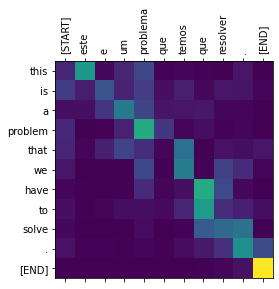

In [32]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [33]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

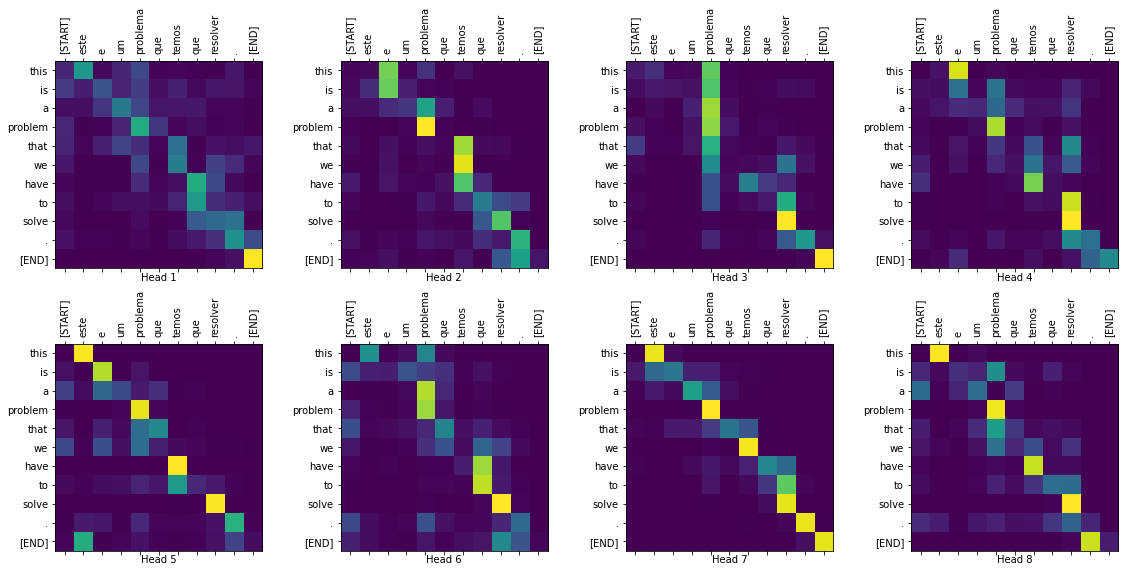

In [34]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])